In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
DRIVE_ROOT = Path('/content/drive/MyDrive')

DATA_ROOT= Path('./data/')
MODEL_ROOT = DRIVE_ROOT / 'weights'

!mkdir -p {DATA_ROOT}
!mkdir -p {MODEL_ROOT}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [3]:
from IPython.display import display

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary
from torchvision import datasets, models, ops, transforms

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

def get_device():
    '''Get device (CPU or GPU).'''
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Network Models

In [4]:
from dataclasses import dataclass

@dataclass
class ModelParameter:
    """ Parameters for Vision Transformer."""
    # Required parameters.
    image_size: int

    # Optional parameters.
    # For the input layer.
    in_channels: int = 3
    patch_size: int = 4
    emb_dim: int = 512
    # For the encoder layers.
    num_heads: int = 8
    mlp_hidden_dim: int = 512
    num_encoder_blocks: int = 6
    # For other modules.
    dropout_rate: float = 0.2

### Input Layer

In [5]:
class InputLayer(nn.Module):
    """Input layer for Vision Transformer using linear patch embedding.

    Attributes:
        image_size: Input image size.
        patch_size: Patch image size in patch embedding.
        emb_dim: Embedding dimension.
        embedding: Linear layer for patch embedding.
        class_token: Parameter for the class token.
        positional_embedding: Parameter for the positional embedding.
    """

    def __init__(self, param: ModelParameter):
        super().__init__()
        assert(param.image_size % param.patch_size == 0)

        self.image_size = param.image_size
        self.patch_size = param.patch_size

        input_dim = (param.patch_size ** 2) * param.in_channels
        self.embedding = nn.Linear(input_dim, param.emb_dim)
        self.class_token = nn.Parameter(torch.randn(1, 1, param.emb_dim)*0.1)

        num_patches = (param.image_size // param.patch_size) ** 2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, param.emb_dim)*0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, C, H, W), where
                B: Batch size.
                C: Number of channels.
                H: Height of the input image.
                W: Width of the input image.
        Returns:
            torch.Tensor: (B, N, D), where
                N: Number of tokens (= number of patches + 1)
                D: Dimension of embedding.
        """
        batch_size, c, h, w = x.shape
        p = self.patch_size

        # Split input images into patches.
        z = x.view(batch_size, c, h//p, p, w//p, p)

        # Flatten each patch into a vector.
        # (B, C, H/P, P, W/P, P) -> (B, H/P, W/P, C, P, P)
        #                        -> (B, num_patches, num_pixels)
        z = z.permute(0, 2, 4, 1, 3, 5)
        z = z.reshape(batch_size, -1, c * p * p)

        # Encode into patch embeddings.
        # (B, Np, num_pixels) -> (B, Np, D)
        z = self.embedding(z)

        # Prepend the class token to the patch embeddings.
        class_token = self.class_token.expand(batch_size, -1, -1)  # (B, 1, D)
        z = torch.cat((class_token, z), dim=1)                     # (B, Np+1, D)

        # Add the positional embeddings.
        z += self.positional_embedding
        return z

### Encoder Block
The encoder block is composed of
* z = Block1(x)
  * Layer Norm
  * Multi-Head Self-Attention
* z = z + x
* o = Block2(z)
  * Layer Nrom
  * MLP
* o = o + z

In [6]:
class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention layer for Vision Transformer.

    Attributes:
        emb_dim: Embedding dimension.
        num_heads: Number of attention heads.
        head_dim: Dimension in each attention head.
        w_q: Linear layer for query projection.
        w_k: Linear layer for key projection.
        w_v: Linear layer for value projection.
        dropout: Dropout layer for attention weights.
        w_o: Output projection layer after concatenating the heads.
    """

    def __init__(self, param: ModelParameter):
        super().__init__()

        self.emb_dim = param.emb_dim
        self.num_heads = param.num_heads
        self.head_dim = param.emb_dim // param.num_heads

        self.w_q = nn.Linear(param.emb_dim, param.emb_dim, bias=False)
        self.w_k = nn.Linear(param.emb_dim, param.emb_dim, bias=False)
        self.w_v = nn.Linear(param.emb_dim, param.emb_dim, bias=False)
        self.dropout = nn.Dropout(param.dropout_rate)

        self.w_o = nn.Sequential(
            nn.Linear(param.emb_dim, param.emb_dim),
#            nn.Dropout(param.dropout_rate)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, N, D)
        Returns:
            torch.Tensor: (B, N, D)
        """
        batch_size, num_patches, _ = x.shape

        # Embed inputs into query, key, and value.
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # (B, N, D) -> (B, N, h, D//h) -> (B, h, N, D//h)
        q = q.view(batch_size, num_patches, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, num_patches, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, num_patches, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute the attention map.
        k_T = k.transpose(2, 3)
        dots = (q @ k_T) / (self.head_dim**0.5)
        attention_map = F.softmax(dots, dim=-1)
        attention_map = self.dropout(attention_map)

        # Multiply the value by the attention map.
        out = attention_map @ v

        out = out.transpose(1, 2)  # (B, N, h, D//h)
        out = out.flatten(2)       # (B, N, D)

        # Unify outputs from each head.
        out = self.w_o(out)
        return out

In [7]:
class EncoderBlock(nn.Module):
    """ Encoder block for Vision Transformer

    Attributes:
        norm1: Normalization layer.
        mhsa: Multi-head self-attention module.
        norm2: Normalization layer.
        mlp: MLP module.
    """

    def __init__(self, param: ModelParameter):
        super().__init__()

        # Block#1.
        self.norm1 = nn.LayerNorm(param.emb_dim)
        self.mhsa = MultiHeadSelfAttention(param)

        # Block#2.
        self.norm2 = nn.LayerNorm(param.emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(param.emb_dim, param.mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(param.dropout_rate),
            nn.Linear(param.mlp_hidden_dim, param.emb_dim),
            nn.Dropout(param.dropout_rate)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, N, D)
        Returns:
            torch.Tensor: (B, N, D)
        """
        x = self.mhsa(self.norm1(x)) + x
        x = self.mlp(self.norm2(x)) + x
        return x

### Vision Transformer

In [8]:
class VisionTransformer(nn.Module):
    """Vision Transformer (ViT) model.

    Composed of a patch embedding layer, stacked encoder blocks, and a classification head.

    Attributes:
        input_layer: Patch embedding layer..
        encoder: Stacked encoder blocks.
        mlp_head: MLP head for classification.
    """

    def __init__(self, num_classes: int, param: ModelParameter):
        super().__init__()

        self.input_layer = InputLayer(param)
        self.encoder = nn.Sequential(
            *[EncoderBlock(param) for _ in range(param.num_encoder_blocks)]
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(param.emb_dim),
            nn.Linear(param.emb_dim, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, C, H, W)
        Returns:
            torch.Tensor: Logits of shape (B, num_classes)
        """
        # (B, C, H, W) -> (B, N, D)
        x = self.input_layer(x)

        # (B, N, D) -> (B, N, D)
        x = self.encoder(x)

        # Extract only the class token.
        # (B, N, D) -> (B, D)
        class_token = x[:, 0]

        # (B, D) -> (B, num_classes)
        out = self.mlp_head(class_token)
        return out

## Train, validate, and run inference

In [9]:
@dataclass
class Config:
    """ Configuration for model training, validation, and inference."""
    num_epochs: int = 50
    batch_size: int = 64
    lr: float = 1e-4
    weight_decay: float = 0.05
    image_size: int = 32
    mean: tuple = (0.4914, 0.4822, 0.4465)
    std: tuple = (0.2470, 0.2435, 0.2616)

In [10]:
class ImageTransform():
    def __init__(self, mode, config, padding=4):
        self.transform = {
            'train' : transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(config.image_size, padding),
                transforms.ToTensor(),
                transforms.Normalize(mean=config.mean, std=config.std),
            ]),
            'val': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=config.mean, std=config.std),
            ]),
        }
        self.mode = mode

    def __call__(self, image):
        return self.transform[self.mode](image)

In [11]:
config = Config()

train_dataset = datasets.CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=ImageTransform('train', config))
test_dataset = datasets.CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=ImageTransform('val', config))

train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(
    test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
def train(model, criterion, optimizer, scheduler, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.train()
    for inputs, labels in tqdm(data_loader, desc='Train', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


@torch.no_grad()
def test(model, criterion, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.eval()
    for inputs, labels in tqdm(data_loader, desc='Test', leave=False):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def train_and_test(num_epochs, model, criterion, optimizer, scheduler, train_loader, test_loader):
    device = get_device()
    train_history = []
    test_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, scheduler, train_loader, device)
        test_loss, test_acc = test(model, criterion, test_loader, device)

        train_history.append([epoch, train_loss, train_acc])
        test_history.append([epoch, test_loss, test_acc])
        print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}')

    return train_history, test_history

In [13]:
num_classes = len(train_dataset.classes)
param = ModelParameter(image_size=config.image_size)
model = VisionTransformer(num_classes, param)
model.to(get_device())

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.num_epochs * len(train_loader)
)

train_history, test_history = train_and_test(
    config.num_epochs, model, criterion, optimizer, scheduler, train_loader, test_loader)

Epoch [1/50], loss: 1.74228 acc: 0.35448 test_loss: 1.48545, test_acc: 0.45340


Epoch [2/50], loss: 1.40383 acc: 0.48576 test_loss: 1.28491, test_acc: 0.53400


Epoch [3/50], loss: 1.24685 acc: 0.54808 test_loss: 1.14450, test_acc: 0.58620


Epoch [4/50], loss: 1.16035 acc: 0.57956 test_loss: 1.09435, test_acc: 0.60870


Epoch [5/50], loss: 1.09278 acc: 0.60842 test_loss: 1.01040, test_acc: 0.64400


Epoch [6/50], loss: 1.03197 acc: 0.63210 test_loss: 0.99210, test_acc: 0.64450


Epoch [7/50], loss: 0.98495 acc: 0.64776 test_loss: 0.98432, test_acc: 0.65370


Epoch [8/50], loss: 0.94251 acc: 0.66160 test_loss: 0.88285, test_acc: 0.69010


Epoch [9/50], loss: 0.90629 acc: 0.67730 test_loss: 0.87344, test_acc: 0.69320


                       ...


                       ...


Epoch [46/50], loss: 0.23767 acc: 0.91534 test_loss: 0.60542, test_acc: 0.81930


Epoch [47/50], loss: 0.23930 acc: 0.91512 test_loss: 0.60627, test_acc: 0.81900


Epoch [48/50], loss: 0.23181 acc: 0.91734 test_loss: 0.60635, test_acc: 0.81910


Epoch [49/50], loss: 0.23273 acc: 0.91652 test_loss: 0.60590, test_acc: 0.81880


Epoch [50/50], loss: 0.23299 acc: 0.91678 test_loss: 0.60587, test_acc: 0.81930


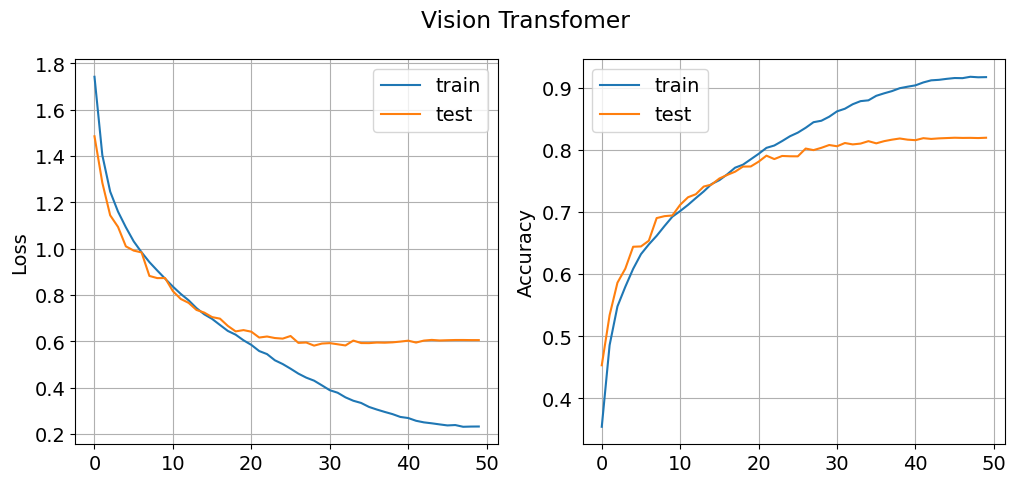

In [14]:
def visualize(train_history, test_history, title=None, figsize=(12,5)):
    train_history = np.array(train_history)
    test_history = np.array(test_history)

    plt.figure(figsize=figsize)
    plt.suptitle(title)

    # Plot training vs testing loss.
    ax = plt.subplot(1, 2, 1)
    ax.set_ylabel('Loss')
    ax.plot(train_history[:, 0], train_history[:, 1], label='train')
    ax.plot(test_history[:, 0], test_history[:, 1], label='test')
    ax.legend()

    # Plot training vs testing accuracy.
    ax = plt.subplot(1, 2, 2)
    ax.set_ylabel('Accuracy')
    ax.plot(train_history[:, 0], train_history[:, 2], label='train')
    ax.plot(test_history[:, 0], test_history[:, 2], label='test')
    ax.legend()

    plt.show()


visualize(train_history, test_history, 'Vision Transfomer')

## Another Implementation of Patch Embedding using Convolutional Layers
* Flexible input for any patch size while the former model requires ```image_size % patch_size = 0```
* Efficient patching and embedding with one convolution

In [15]:
class ConvInputLayer(nn.Module):
    """ Input layer for Vision Transformer using convolutional layers.

    Attributes:
        patch_embedding: Convolutional layer for patch embedding.
        class_token: Parameter for class token.
        positional_embedding: Parameter for positional embedding.
    """
    def __init__(self, param: ModelParameter):
        super().__init__()

        self.patch_embedding = nn.Conv2d(
            in_channels=param.in_channels,
            out_channels=param.emb_dim,
            kernel_size=param.patch_size,
            stride=param.patch_size
        )

        self.class_token = nn.Parameter(torch.randn(1, 1, param.emb_dim)*0.1)

        num_patches = (param.image_size // param.patch_size) ** 2
        self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, param.emb_dim)*0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, C, H, W)
        Returns:
            torch.Tensor: (B, N, D)
        """
        batch_size = x.shape[0]

        # Encode into patch embeddings.
        z = self.patch_embedding(x)  # (B, C, H, W) -> (B, D, H/P, W/P)
        z = z.flatten(2)             # (B, D, H/P, W/P) -> (B, D, Np)
        z = z.transpose(1, 2)        # (B, D, Np) -> (B, Np, D)

        # Prepend the class token to the patch embeddings.
        class_token = self.class_token.expand(batch_size, -1, -1)  # (B, 1, D)
        z = torch.cat((class_token, z), dim=1)                     # (B, Np+1, D)

        # Add the positional embeddings.
        z += self.positional_embedding
        return z

Epoch [1/50], loss: 1.72849 acc: 0.35792 test_loss: 1.45147, test_acc: 0.47370


Epoch [2/50], loss: 1.38526 acc: 0.49498 test_loss: 1.22139, test_acc: 0.55910


Epoch [3/50], loss: 1.23652 acc: 0.55400 test_loss: 1.12978, test_acc: 0.58360


Epoch [4/50], loss: 1.14911 acc: 0.58540 test_loss: 1.06797, test_acc: 0.61920


Epoch [5/50], loss: 1.08027 acc: 0.61010 test_loss: 1.02545, test_acc: 0.62220


Epoch [6/50], loss: 1.02559 acc: 0.63096 test_loss: 0.98405, test_acc: 0.65090


Epoch [7/50], loss: 0.98253 acc: 0.64750 test_loss: 0.93304, test_acc: 0.66580


Epoch [8/50], loss: 0.93485 acc: 0.66378 test_loss: 0.89829, test_acc: 0.67270


Epoch [9/50], loss: 0.90178 acc: 0.67676 test_loss: 0.83776, test_acc: 0.70660


                       ...


                       ...


Epoch [46/50], loss: 0.24103 acc: 0.91368 test_loss: 0.60308, test_acc: 0.82170


Epoch [47/50], loss: 0.23872 acc: 0.91492 test_loss: 0.59962, test_acc: 0.82130


Epoch [48/50], loss: 0.24007 acc: 0.91440 test_loss: 0.60099, test_acc: 0.81970


Epoch [49/50], loss: 0.23781 acc: 0.91500 test_loss: 0.60106, test_acc: 0.82090


Epoch [50/50], loss: 0.23098 acc: 0.91876 test_loss: 0.60156, test_acc: 0.82060


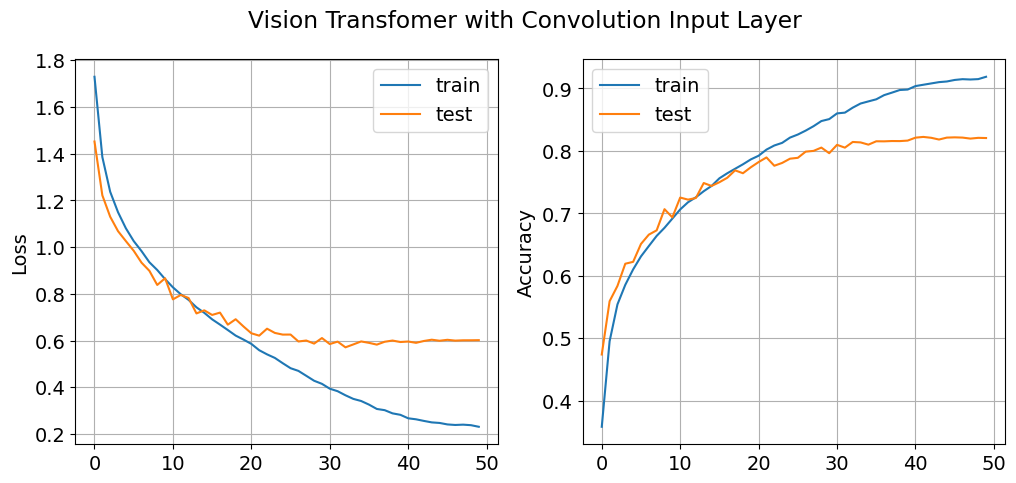

In [16]:
model = VisionTransformer(num_classes, param)
model.input_layer = ConvInputLayer(param)
model.to(get_device())

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.num_epochs * len(train_loader)
)

train_history, test_history = train_and_test(
    config.num_epochs, model, criterion, optimizer, scheduler, train_loader, test_loader)
visualize(train_history, test_history, 'Vision Transfomer with Convolution Input Layer')